In [1]:
import sys
sys.path.append('./../../designer/script/')
sys.path.append('./../')
sys.path.append('./../../')

import film as film_mod
import design as design_mod
import spectrum as spec_mod
from optimizer.adam import AdamThicknessOptimizer
from utils.loss import calculate_RMS_f_spec

from analyze_utils.make_design import make_reflection_design

import numpy as np
import matplotlib.pyplot as plt
import pickle
import copy

from analyze_utils.structure import plot_layer_thickness
from utils.loss import calculate_RMS_f_spec, calculate_RMS
from utils.get_n import get_n_SiO2, get_n_TiO2
import matplotlib.cm as cmap


ImportError: cannot import name 'NDArray' from 'numpy.typing' (C:\Users\rfeng6\AppData\Roaming\Python\Python39\site-packages\numpy\typing\__init__.py)

## Different Batch Size

In [ ]:
def make_rand_new_film():
    d = np.random.random(200) * 30 # smaller ot allows for fewer configurations
    film = film_mod.TwoMaterialFilm('SiO2', 'TiO2', 'SiO2', d)
    return film

design = make_reflection_design(make_rand_new_film())
target: list[spec_mod.BaseSpectrum] = design.target_specs

rep = 1
batches = [10]

loss_rep_ls = []
film_rep_ls = []
best_film_rep_ls = []
for _ in range(rep):
    loss_ls = []
    film_ls = []
    best_film_ls = []

    for wl_batch in batches:
        f = make_rand_new_film()
        adam_optimizer = AdamThicknessOptimizer(
            f, 
            target, 
            2000, 
            alpha=1.5, 
            batch_size_wl=wl_batch, 
            show=True, 
            record=True, 
        )
        # it is worth noting here that the validation is on the whole set 
        # i.e. best possible performance for mini-batching
        films, losses = adam_optimizer() 
        loss_ls.append(losses)
        film_ls.append(films)
        best_film_ls.append(copy.deepcopy(f))
    loss_rep_ls.append(loss_ls)
    film_rep_ls.append(film_ls)
    best_film_rep_ls.append(best_film_ls)


working_file = './batches'
with open(working_file, 'wb') as file:
    pickle.dump({
        'batches': batches, 
        'film': film_rep_ls, 
        'loss': loss_rep_ls, 
        'best_film': best_film_rep_ls, 
        'target': target
    }, file)

In [7]:
working_file = './raw_result/batches'

with open(working_file, 'rb') as file:
    d = pickle.load(file)
    batches = d['batches']
    film_rep_ls = d['film']
    loss_rep_ls = d['loss']
    best_film_rep_ls = d['best_film']
    target = d['target']
print('loaded')


loaded


In [6]:
calculate_RMS_f_spec(best_film_rep_ls[0][0], target)
# calculate_RMS_f_spec(film_rep_ls[0][0][-1], target)

0.03168651938082538

batch size: 0.002, best loss: 0.0290348915336007, last loss: 0.029046960531407207


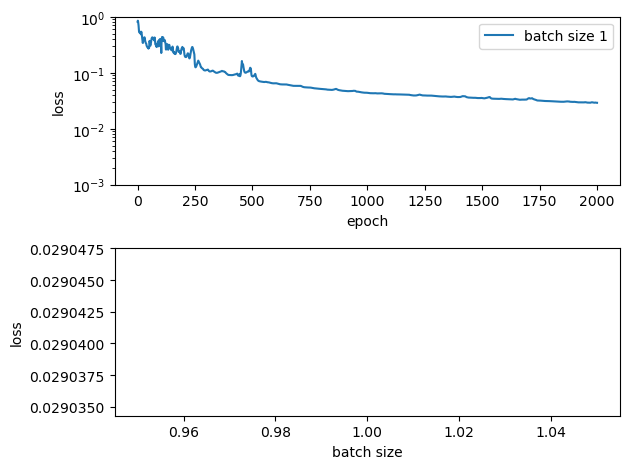

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1)
loss_rep_ls = np.array(loss_rep_ls)
loss_ls = loss_rep_ls.mean(axis=0)
loss_std_ls = loss_rep_ls.std(axis=0)
for losses, loss_std, batch_size in zip(loss_ls, loss_std_ls, batches):
    ax1.plot(losses, label=f'batch size {batch_size}')
    ax1.fill_between(range(len(losses)), losses - loss_std, losses + loss_std, alpha=0.4)
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_yscale('log')
ax1.set_ylim(1e-3, None)
ax1.legend()

best_loss_rep_ls = [[calculate_RMS_f_spec(film, target) for film in best_film_ls] for best_film_ls in best_film_rep_ls ]
best_loss_rep_ls = np.array(best_loss_rep_ls)
best_loss_mean = best_loss_rep_ls.mean(axis=0)
best_loss_std = best_loss_rep_ls.std(axis=0)
ax2.plot(batches, best_loss_mean)
ax2.fill_between(batches, best_loss_mean - best_loss_std, best_loss_mean + best_loss_std, alpha=0.4, label='best')

last_loss_rep_ls = [[calculate_RMS_f_spec(films[-1], target) for films in film_ls] for film_ls in film_rep_ls]
last_loss_rep_ls = np.array(last_loss_rep_ls)
last_loss_mean = last_loss_rep_ls.mean(axis=0)
last_loss_std = last_loss_rep_ls.std(axis=0)
ax2.plot(batches, last_loss_mean)
ax2.fill_between(batches, last_loss_mean - last_loss_std, last_loss_mean + last_loss_std, alpha=0.4, label='last')

ax2.set_xlabel('batch size')
ax2.set_ylabel(f'loss')

fig.tight_layout()

for i, batch in enumerate(batches):
    print(f'batch size: {batch / 500}, best loss: {best_loss_mean[i]}, last loss: {last_loss_mean[i]}')

Text(0.5, 1.0, 'loss: 0.04464590486638516')

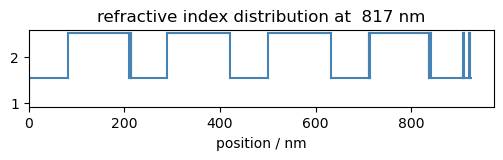

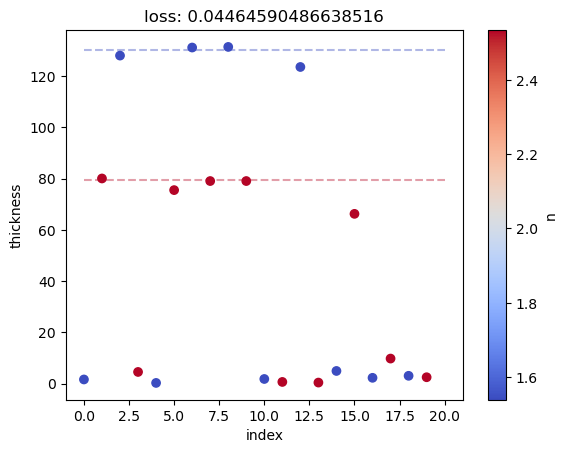

In [ ]:

def plot_thickness_idx(f):
    d = f.get_d()
    fig, ax = plt.subplots(1, 1)
    wl = np.array([750.])
    s = ax.scatter(range(d.shape[0]), d, marker='o', cmap='coolwarm', c=f.calculate_n_array(wl)[0, :])
    cbar = fig.colorbar(s)
    cbar.set_label('n')

    # target: 800 nm DBR
    wl = 800.
    d_SiO2 = wl / 4 / get_n_SiO2(wl)
    d_TiO2 = wl / 4 / get_n_TiO2(wl)
    
    ax.plot([0, d.shape[0]], [d_SiO2, d_SiO2], c=cmap.get_cmap('coolwarm')(0), alpha=0.4, ls='--')
    ax.plot([0, d.shape[0]], [d_TiO2, d_TiO2], c=cmap.get_cmap('coolwarm')(0.99), alpha=0.4, ls='--')
    ax.set_xlabel('index')
    ax.set_ylabel('thickness')
    return fig, ax

f: film_mod.TwoMaterialFilm = film_rep_ls[6][0][-1] # 5, 19, 50, 64, 68, 89
f.add_spec_param(target[0].INC_ANG, target[0].WLS)
f.remove_negative_thickness_layer()

plot_layer_thickness(f)
_, ax = plot_thickness_idx(f)
ax.set_title(f'loss: {calculate_RMS_f_spec(f, target)}')

## Different OT - Bragg structure